torch.Size([2, 5000])
torch.Size([5000])


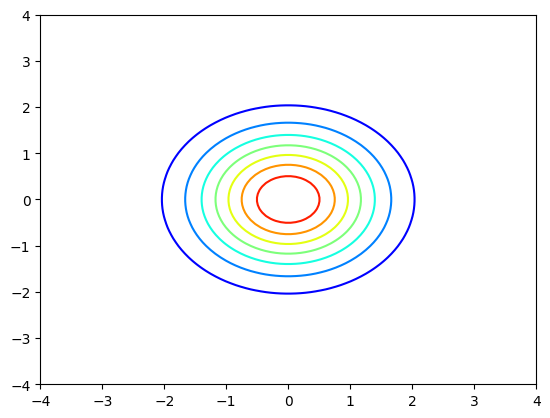

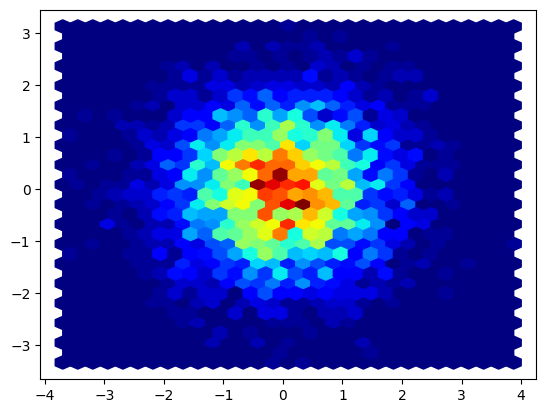

In [507]:
import torch
import matplotlib.pyplot as plt

## Create Dataset
dn = 100
range_xy = torch.linspace(start=-4,end=4,steps=dn)
gridx, gridy = torch.meshgrid(range_xy,range_xy)

datax = torch.flatten(gridx)
datay = torch.flatten(gridy)
com_data = torch.stack((datax,datay))

q0_func_grid = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(2), torch.eye(2))
q0_grid = torch.exp(q0_func_grid.log_prob(com_data.T)).reshape(dn,dn)

plt.figure(1)
plt.contour(gridx,gridy,q0_grid,cmap=plt.cm.jet)

n = 5000
gridsize = 30
q0_func = torch.distributions.Normal(loc=torch.tensor([0.0, 0.0]), scale=torch.tensor([[1.0, 1.0]]))
z0 = q0_func.sample((n,)).reshape(2,n)
q0 = q0_func_grid.log_prob(z0.T)

print(z0.shape)
print(q0.shape)

plt.figure(2)
plt.hexbin(z0[0,:], z0[1,:], gridsize=gridsize, cmap=plt.cm.jet, bins=None)

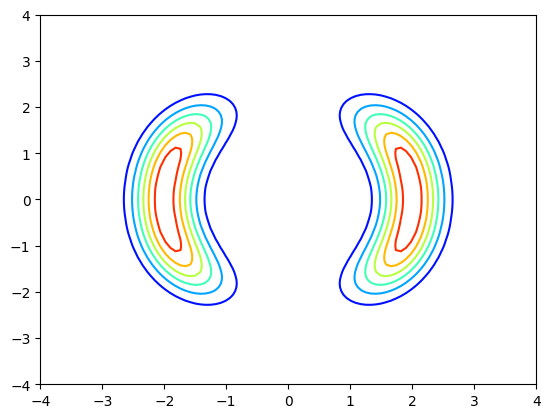

In [508]:
# Create Reference Output
data_norm = torch.sqrt(torch.pow(datax,2) + torch.pow(datay,2))

C1 = torch.mul(0.5,torch.pow(torch.div(data_norm - 2,0.4),2))
C2 = torch.mul(-0.5,torch.pow(torch.div(datax - 2,0.6),2))
C3 = torch.mul(-0.5,torch.pow(torch.div(datax + 2,0.6),2))
C4 = torch.logaddexp(C2,C3)

qn_ref_grid = torch.exp(-(C1 - C4))
qn_ref_plot = torch.reshape(qn_ref_grid,(100,100))

plt.figure(3)
plt.contour(gridx,gridy,qn_ref_plot,cmap=plt.cm.jet)

data_norm = torch.sqrt(torch.pow(z0[0,:],2) + torch.pow(z0[1,:],2))

C1 = torch.mul(0.5,torch.pow(torch.div(data_norm - 2,0.4),2))
C2 = torch.mul(-0.5,torch.pow(torch.div(z0[0,:] - 2,0.6),2))
C3 = torch.mul(-0.5,torch.pow(torch.div(z0[0,:] + 2,0.6),2))
C4 = torch.logaddexp(C2,C3)

qn_ref = torch.exp(-(C1 - C4))

In [509]:
## Create Single Layer of Discrete Normalizing Flow
class Planar_Layer(torch.nn.Module):
    def __init__(self,d):
        super(Planar_Layer,self).__init__()
        self.u = torch.nn.Parameter(torch.Tensor(1, d), requires_grad=True)
        self.w = torch.nn.Parameter(torch.Tensor(1, d), requires_grad=True)
        self.b = torch.nn.Parameter(torch.Tensor(1), requires_grad=True)
        self.h = torch.tanh
        self.init_params()

    def init_params(self):
        self.w.data.uniform_(-0.01, 0.01)
        self.b.data.uniform_(-0.01, 0.01)
        self.u.data.uniform_(-0.01, 0.01)
        
    def forward(self, z):
        #m = -1 + torch.log(1+torch.exp(torch.Tensor(1)))
        #if torch.matmul(self.w,self.u.T) < -1:
        #    u_hat = self.u + torch.matmul(self.w.T,(m*torch.matmul(self.w,self.u.T) - torch.matmul(self.w,self.u.T))/torch.linalg.norm(self.w)).T
        #    print(torch.linalg.norm(self.w))
        #else:
        #    u_hat = self.u
            
        zL = z + torch.matmul(self.u.T,self.h(torch.matmul(self.w,z) + self.b))
        psi = torch.outer(torch.flatten(self.w.T),torch.flatten((1-torch.pow(self.h(torch.matmul(self.w,z)+self.b),2))))
        ln_q_zL = torch.log(torch.abs(1 + torch.matmul(self.u,psi)))
        
        #zL = z + torch.matmul(u_hat.T,self.h(torch.matmul(self.w,z) + self.b))
        #intermediate = torch.outer(torch.flatten(self.w.T),torch.flatten((1-torch.pow(self.h(torch.matmul(self.w,z)+self.b),2))))
        #ln_q_zL = torch.log(torch.abs(1 + torch.matmul(u_hat,intermediate)))
        #print(torch.min(1 + torch.matmul(u_hat,intermediate)))
        return zL, ln_q_zL
    
## Create Discrete Normalizing Flows Class
class DNF(torch.nn.Module): # torch only tracks parameters with autograd when requires_grad=True
    def __init__(self,d,L):
        super(DNF,self).__init__()
        self.layers = torch.nn.ModuleList([Planar_Layer(d) for _ in range(L)])
        
    def forward(self, x: torch.Tensor) -> torch.Tensor: # forward is a required part, this defines what to do in the forward pass of the nn, automatically
        zL = x
        sigma_ln_q_zL = 0
               
        for layer in self.layers:
            zL, ln_q_zL = layer.forward(zL)
            sigma_ln_q_zL += ln_q_zL
            
            return zL, ln_q_zL

In [510]:
## Define Batching Process
# testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [511]:
## Define NN Hyper-Parameters
d = 2         # dimension of input data
L = 32        # HYPERPARAMETER: number of sequencial layers
a = 0.01     # HYPERPARAMETER: Learning Rate
theta = 0.9   # HYPERPARAMETER: Momentum Coefficient
e = 1000      # HYPERPARAMETER: Number of epochs
b = 100       # HYPERPARAMETER: batch size

model = DNF(d,L)
loss_eval = torch.nn.L1Loss()
optimizer = torch.optim.RMSprop(params=model.parameters(),lr=a,momentum=theta)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1000)

for i in range(e):
    model.train()             # this command tells pytorch to track gradients
    optimizer.zero_grad()     # zero out gradients for all model parameters, value is accumulated not replaced!
    zL, ln_q_zL = model(z0)   # do forward propogation
    qn_pred = q0 - ln_q_zL    # Compute log probability density after transformation
    
    #loss = loss_eval(torch.exp(qn_pred),qn_ref)
    loss = loss_eval(torch.exp(qn_pred),qn_ref)
    
    loss.backward()           # update gradients for each model parameter 
    optimizer.step()          # update each model parameter using gradient descent
    #scheduler.step(loss)
    
    #model.eval() # this command tells pytorch to not track gradients    

torch.Size([2, 5000])


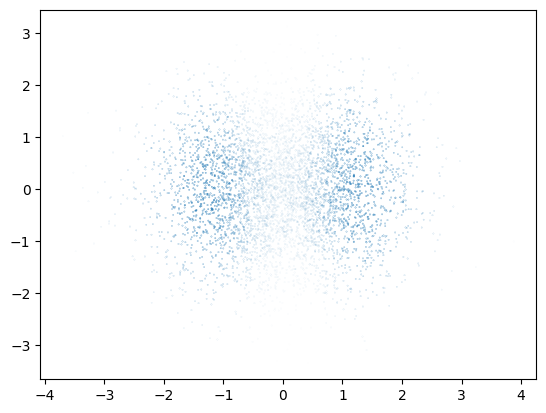

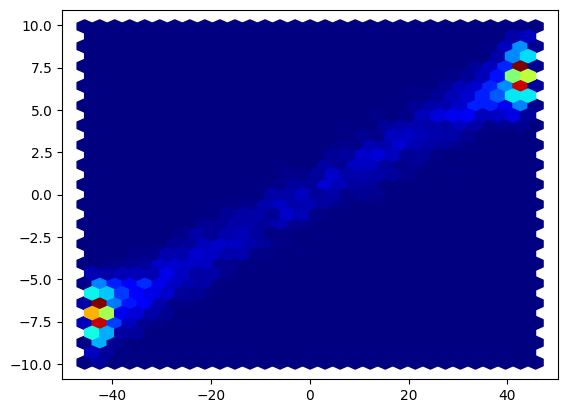

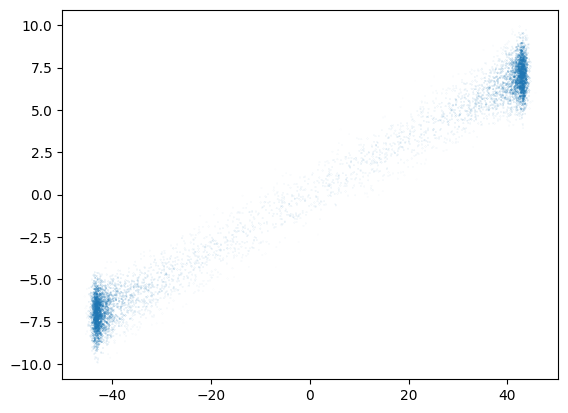

In [512]:
print(zL.shape)
plt.figure(5)
plt.scatter(z0[0,:], z0[1,:], torch.exp(qn_pred).detach().numpy())

plt.figure(6)
plt.hexbin(zL[0,:].detach().numpy(), zL[1,:].detach().numpy(), gridsize=gridsize, cmap=plt.cm.jet, bins=None)

plt.figure(7)
plt.scatter(zL[0,:].detach().numpy(), zL[1,:].detach().numpy(), torch.exp(qn_pred).detach().numpy())

#plt.figure(7)
#plt.contour(zL[0,:].detach().numpy(), zL[1,:].detach().numpy(),torch.exp(qn_pred).detach().numpy(),cmap=plt.cm.jet)